In [1]:
import torch
from torch import nn
from torch import tensor
from torch.utils.data import  DataLoader
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import argparse
import os
pd.set_option('display.max_columns', None)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def model_parameters_init(model):
    '''
    kaiming init
    '''
    for p in model.parameters():
        if len(p.shape) >= 2:
            nn.init.kaiming_normal_(p)
    return model

In [3]:
class NetWork(nn.Module):
    '''
    只输入一个aqi，其他置0
    '''
    def __init__(self):
        super(NetWork,self).__init__()
        self.lstm = nn.LSTM(24, 50, 1, batch_first= True)
        self.linear_1 = nn.Linear(50, 50)
        self.linear_2 = nn.Linear(50, 1)
        self.relu = nn.PReLU()
        self.dropout = nn.Dropout(0.2)
#         self.bn = nn.BatchNorm1d(50)
        
    def forward(self, x):
        x,(h_1,c_1) = self.lstm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = x.squeeze(2)
        return x

In [4]:
class ToTensor(object):
    '''
    transform sample to tensor
    '''
    def __call__(self, sample):
        sample['x'] = torch.from_numpy(sample['x']).float()
        sample['y'] = torch.from_numpy(sample['y']).float()
        return sample

In [5]:
class AqiDataset():
    '''
    用于获取aqi训练与测试数据
    '''
    def __init__(self, data, transforms= None):
        '''
        data: samples of ndarray from csv
        '''
        self.data = data.copy()
        #第一个气象要素用不到，只取aqi
        #后面71个取不到
        self.size = len(data) - 72
        self.transforms = transforms
    
    def __call__(self):
        print('使用__getitem__(idx)获取数据')
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        '''
        定义了__getitem__魔法函数，该类就可以下标操作了：[]
        '''
        #取此时刻的aqi
        aqi = self.data[idx,0]
        #将aqi放到下一个时刻的特征上
        mete_factors = self.data[idx + 1 : idx + 73].copy()
        mete_factors[:,0] = 0
        mete_factors[0,0] = aqi
        #取各个时刻的实测值
        lables = self.data[idx + 1 : idx + 73, 0].copy()
        #进行必要的变换
        sample = {'x':mete_factors, 'y':lables}
        sample = self.transforms(sample)
        return sample

In [6]:
def train(args, train_loader, valid_loader, model, criterion, optimizer, scheduler, device):
    #save model or not
    if args.save_model:
        if not os.path.exists(args.save_directory):
            os.makedirs(args.save_directory)
    
    epochs = args.epochs
    train_losses = []
    valid_losses = []
    for epoch_id in range(epochs):
        #monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        ######################
        #training the model#
        ######################
        train_batch_cnt = 0
        for batch_idx, batch in enumerate(train_loader):
            train_batch_cnt += 1
            x = batch['x']
            y = batch['y']
            
            # groundtruth
            x = x.to(device)
            y = y.to(device)
            
            #clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            #get out_puts
            pred_y = model(x)
            
            #get loss
            loss = criterion(y, pred_y)
            train_loss += loss.item()
            
            #do bp
            loss.backward()
            optimizer.step()
            
            #show log info
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]  MSELoss: {:.6f}'.format(
                        epoch_id,
                        batch_idx * len(x),
                        len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item()
                        )
                      )
        #记录train_loss
        train_loss /= train_batch_cnt
        train_losses.append(train_loss)
            
        ######################
        # validate the model #
        ######################
        valid_loss = 0.0
        #change model mode to eval ,not use BN/Dropout
        model.eval()
        with torch.no_grad():
            valid_batch_cnt = 0

            for valid_batch_idx, batch in enumerate(valid_loader):
                valid_batch_cnt += 1
                x = batch['x']
                y = batch['y']

                x = x.to(device)
                y = y.to(device)

                pred_y = model(x)
                
                valid_loss_batch = criterion(y, pred_y)
                valid_loss += valid_loss_batch.item()

            valid_loss /= valid_batch_cnt * 1.0
            #记录valid_loss
            valid_losses.append(valid_loss)
            print('Valid: MSELoss: {:.6f}'.format(valid_loss))
        #学习率衰减
        scheduler.step()
        print('===========================================================')
        #save model
        if args.save_model and epoch_id % 10 == 0:
            saved_model_name = os.path.join(args.save_directory, 'epoch' + '_' + str(epoch_id) + '.pt')
            torch.save(model.state_dict(), saved_model_name)
    return train_losses, valid_losses

In [7]:
def test(args, valid_loader, model, criterion, device):
    path_model = os.path.join(args.save_directory, 'epoch' + '_' + str(args.number) + '.pt')
    model.load_state_dict(torch.load(path_model))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        valid_batch_cnt = 0
        valid_loss = 0
        for valid_batch_idx, batch in enumerate(valid_loader):
            valid_batch_cnt += 1
            x = batch['x']
            y = batch['y']

            x = x.to(device)
            y = y.to(device)
            pred_y = model(x)

            valid_loss_batch = criterion(y, pred_y)
            valid_loss += valid_loss_batch.item()

        valid_loss /= valid_batch_cnt * 1.0
        print('Valid: MSELoss: {:.6f}'.format(valid_loss))

In [12]:
def predict(args, val_set, model, device):
    path_model = os.path.join(args.save_directory, 'epoch' + '_' + str(args.number) + '.pt')
    model.load_state_dict(torch.load(path_model))
    model = model.to(device)
    model.eval()
    data = val_set[args.idx]
    with torch.no_grad():
        x = data['x'].to(device).unsqueeze(0)
        y = data['y'].numpy()
        pred_y = model(x)
        pred_y = pred_y.cpu().numpy()
        plt.figure(0,(8,6))
        plt.plot(range(len(y)),y,'b-o')
        plt.plot(range(len(y)),pred_y[0],'r-o')
        plt.xlabel('Following 72 Hours')
        plt.ylabel('AQI')
        plt.legend(['obs','predict'])
        plt.show()

In [13]:
def main(args):
    #设置随机种子
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    #设置CPU/GPU
    use_cuda = args.cuda and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    ###############################################################################################################
    print('===> Loading Datasets')
    #读数据
    df = pd.read_csv('data/aqi_upsample.csv',index_col= 0)
    data = df.values
    data[:,4] /= 10000
    #划分样本集
    trsf = transforms.Compose([ToTensor()])
    train_set = AqiDataset(data[:18000], trsf)
    test_set = AqiDataset(data[18000:27000], trsf)
    val_set = AqiDataset(data[27000:], trsf)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=False, num_workers= 1, pin_memory= False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.test_batch_size, num_workers= 1, pin_memory= False)
    ###############################################################################################################
    print('===> Building Model')
    print('===> runing on {}'.format(device))
    ###############################################################################################################
    print('===> init model')
    model = NetWork()
    ###############################################################################################################
    model.to(device)
    criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr= args.lr)
    optimizer = optim.SGD(model.parameters(), lr = args.lr, momentum= args.momentum)
    #学习率衰减
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1 , 0.9)
    ###############################################################################################################
    if args.phase == 'Train' or args.phase == 'train':
        print('===> Start Training')
        train_losses, valid_losses = train(args, train_loader, test_loader, model, criterion, optimizer, scheduler, device)
        print('===> Done!')
        return train_losses, valid_losses
        
    elif args.phase == 'Test' or args.phase == 'test':
        print('===> Test')
        test(args, test_loader, model, criterion, device)
        print('===> Done!')
        return None, None
    elif args.phase == 'Finetune' or args.phase == 'finetune':
        print('===> Finetune')
        path_model = os.path.join(args.save_directory, 'epoch' + '_' + str(args.number) + '.pt')
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)
        train_losses, valid_losses = train(args, train_loader, valid_loader, model, criterion, optimizer, scheduler, device)
        print('===> Done!')
        return train_losses, valid_losses
        
    elif args.phase == 'Predict' or args.phase == 'predict':
        print('===> Predict')
        predict(args, val_set, model, device)
        print('===> Done!')
        return None, None

===> Loading Datasets
===> Building Model
===> runing on cuda
===> init model
===> Predict


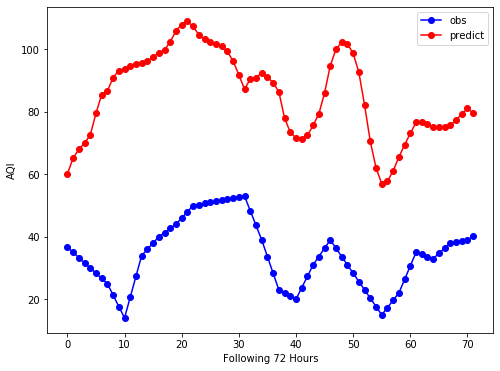

===> Done!
耗时：0.24967360496520996s


In [23]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Detector')
    parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test_batch_size', type=int, default=256, metavar='N',
                        help='input batch size for testing (default: 256)')
    parser.add_argument('--predict_batch_size', type=int, default=1, metavar='N',
                        help='input batch size for predict (default: 1)')
    parser.add_argument('--epochs', type=int, default=50, metavar='N',
                        help='number of epochs to train (default: 100)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--cuda', action='store_true', default=False,
                        help='enables CUDA training')
    parser.add_argument('--seed', type=int, default=10, metavar='S',
                        help='random seed (default: 10)')
    parser.add_argument('--log_interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save_model', action='store_true', default=False,
                        help='save the current Model')
    parser.add_argument('--save_directory', type=str, default='trained_models',
                        help='learnt models are saving here')
    parser.add_argument('--phase', type=str, default='Train',   # Train/train, Predict/predict, Finetune/finetune
                        help='training, predicting or finetuning')
    parser.add_argument('--number', type=int, default=0,
                        help='which model to use')
    parser.add_argument('--idx', type=int, default=0,
                        help='which sample to predict')
    args = parser.parse_args(['--batch_size=64',
                              '--test_batch_size=2048',
                              '--predict_batch_size=1',
                              '--epochs=21',
                              '--lr=0.00001',
                              '--momentum=0.2',
                              '--cuda',
                              '--seed=1',
                              '--log_interval=50',
                              '--save_model',
                              '--save_directory=trained_models_1',
                              '--number=9999',
                              '--idx=1750',
                              '--phase=predict'])
    ##############################################################################################################
    start = time.time()
    train_losses, valid_losses = main(args)
    end = time.time()
    print('耗时：{}s'.format(end - start))
    torch.cuda.empty_cache()

In [11]:
#读数据
df = pd.read_csv('data/aqi_upsample.csv',index_col= 0)
data = df.values
data[:,4] /= 10000
#划分样本集
trsf = transforms.Compose([ToTensor()])
train_set = AqiDataset(data[:18000], trsf)
test_set = AqiDataset(data[18000:27000], trsf)
val_set = AqiDataset(data[27000:], trsf)

In [42]:
val_set[2300]

{'x': tensor([[ 1.7000e+01,  1.1740e+01, -6.2700e+00,  ...,  0.0000e+00,
           0.0000e+00, -7.1000e-01],
         [ 0.0000e+00,  1.1990e+01, -6.5600e+00,  ...,  0.0000e+00,
           0.0000e+00, -5.7000e-01],
         [ 0.0000e+00,  1.2240e+01, -6.8600e+00,  ...,  0.0000e+00,
           0.0000e+00, -4.2000e-01],
         ...,
         [ 0.0000e+00,  2.0990e+01, -1.2860e+01,  ...,  0.0000e+00,
           0.0000e+00, -5.0000e-02],
         [ 0.0000e+00,  2.0450e+01, -1.2790e+01,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e-02],
         [ 0.0000e+00,  1.9900e+01, -1.2720e+01,  ...,  0.0000e+00,
           0.0000e+00,  8.0000e-02]]),
 'y': tensor([16.0000, 16.1100, 16.2200, 16.3300, 16.4400, 16.5600, 16.6700, 16.7800,
         16.8900, 17.0000, 18.3300, 19.6700, 21.0000, 21.3300, 21.6700, 22.0000,
         22.3300, 22.6700, 23.0000, 24.0800, 25.1500, 26.2300, 27.3100, 28.3800,
         29.4600, 30.5400, 31.6200, 32.6900, 33.7700, 34.8500, 35.9200, 37.0000,
         38.0800, 39